In [6]:
from glob import glob
from IPython.display import display
from osgeo import gdal, osr
from skimage.metrics import peak_signal_noise_ratio as psnr
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

In [7]:
class CalibImg:
    def __init__(self, img_path):
        self.imgPath = img_path
        self.ds = self.get_array()[:-1]
        self.array = self.get_array()[-1]

    def get_array(self):
        img = gdal.Open(self.imgPath)
        band = img.GetRasterBand(1)
        return img, self.imgPath, band.ReadAsArray()
    
    def get_name(self, path=None):
        try:
            name_split = self.imgPath.split('/')[1]
        except AttributeError:
            name_split = path.split('/')[1]
        name_split = name_split.replace('\\', '_')
        return name_split[:-5]

In [8]:
class RawImg(CalibImg):
    def __init__(self, img_path, meta_path):
        super().__init__(img_path)        
        self.metaPath = meta_path
        self.meta = self.get_meta() 
            
    def get_meta(self):
        with open(self.metaPath, "r") as meta:
            return json.load(meta)

In [9]:
class CorrectedImg(CalibImg):
    def __init__(self, img_array, raw_img, count):
        self.array = img_array
        self.raw = raw_img     
        self.count = count
            
    def histCorr(self):
        
        def plotColAvgs(avgs):
            plt.figure(figsize=(15,15))
            plt.title('Average pixel intensity by column')
            plt.plot(avgs)

        avg_by_col = np.mean(self.array, axis=0)
        plotColAvgs(avg_by_col)
        
        # Create a mask for anomalous values
        ratios = np.divide(avg_by_col, avg_by_col.mean())
        mask_greater = ratios > 3 
        mask_lower = ratios < 0.3
        mask = np.logical_or(mask_greater, mask_lower)
        mask.reshape(-1, 1)

        # Compute averages by row
        real_avg_by_row = np.mean(self.array[:, ~mask], axis=1)
        other_avg_by_row = np.mean(self.array[:, mask], axis=1)
        ratios_row = (real_avg_by_row / other_avg_by_row).reshape(-1, 1)        

        if np.isnan(ratios_row).any():
            ratios_row = np.ones((self.array.shape[0], 1))

        corrected = np.where(mask, self.array * ratios_row, self.array)
        corrected = corrected.astype('int')

        # Plot the new column average
        avg_by_col = np.mean(corrected, axis=0)
        plotColAvgs(avg_by_col)
            
        return corrected
    
    def save(self):
    
        driver = gdal.GetDriverByName("GTiff")
        output = driver.Create(f'out/img{self.count}_({self.get_name(self.raw.ds[1])}).tiff', self.array.shape[1], 
                               self.array.shape[0], 1, gdal.GDT_Int32)
        proj = osr.SpatialReference()
        proj.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')                
        output.SetProjection(proj.ExportToWkt())
        output.SetGeoTransform(self.raw.ds[0].GetGeoTransform())
        band = output.GetRasterBand(1).WriteArray(self.array)
        band = None

In [10]:
def visCalibFields(dark, flat):
    plt.figure(figsize=(15,15))
    plt.subplot(121)
    plt.imshow(dark.array, cmap='gray')
    
    plt.title(dark.get_name())
    plt.subplot(122)
    plt.imshow(flat.array, cmap='gray')
    plt.title(flat.get_name())

In [11]:
def radErrChecks(img, idx, swidth): 
    
    # Random noise
    nan_any = np.isnan(img.array).any()
    # Line drop
    nan_row = np.isnan(img.array).all(axis=1).any()
    # Bad line start
    bad_start = img.array.shape[1] != swidth
    
    if nan_any or nan_row or bad_start:
        print(f'Warning, Radiometric error detected in the raw image list (index {idx}):')      
        if bad_start:
            print('Bad line start detected')
        elif nan_row:
            print('Line drop detected')
        else:
            print('Random noise detected')

In [12]:
def applyFFC(img, dark, flat):
 
    # Read metadata
    start_row = img.meta['band_start_row']
    tdi = img.meta['num_tdi']
    
    # Subset the fields to the relevant rows (based on start row and tdi)
    dark_sub = dark.array[start_row:start_row+tdi, :]
    flat_sub = flat.array[start_row:start_row+tdi, :]    
    
    # Compute the mean by column (since these sensor rows generate a single pixel in the raw image)
    dark_row = np.mean(dark_sub, axis=0)
    flat_row = np.mean(flat_sub, axis=0)
    
    # The DN of sensor rows are added together, thus divide the raw array by the tdi to get the average pixel value detected
    img.array = img.array / tdi

    # Match the shape of the final image
    dark_final = np.vstack([dark_row] * img.array.shape[0])
    flat_final = np.vstack([flat_row] * img.array.shape[0])
    
    '''Correct the images using the flat-field correction (FFC):
    
    This can be calculated as:
    (raw - dark) * avg(flat - dark) / (flat - dark)
    
    which simplified:
    (raw - dark) * gain
    
    where gain = avg(flat - dark) / (flat - dark)
    '''    
    
    m = np.mean(np.subtract(flat_final, dark_final))
    gain = np.divide(m, np.subtract(flat_final, dark_final))
        
    post_ffc = np.subtract(img.array, dark_final) * gain
    post_ffc = np.multiply(post_ffc, tdi)
    post_ffc = post_ffc.astype('int')

    # Compansate for negative values
    if post_ffc.min() < 0:
        post_ffc = np.subtract(post_ffc, post_ffc.min())
        
    return post_ffc

In [13]:
def visPrePost(img_pre, img_post):
    fig, ax = plt.subplots(1, 2, figsize=(15,15))
    fig.suptitle(f'Visualisation for {img_pre.get_name()}')
    ax[0].imshow(img_pre.array)
    ax[0].set_title('Raw image')
    ax[1].imshow(img_post)
    ax[1].set_title('After correction')
    plt.show()

In [14]:
def corrMetrics(img_pre, img_post):
    # Calculate the intensity shift by pixel
    shift = np.subtract(img_pre.array, img_post)
    
    # Visualise the range of intensity shifts
    fig, ax = plt.subplots(figsize=(15,15))
    plt.boxplot(shift.flatten())
    ax.set(ylabel="Intensity shift (DN)")
    plt.title(f'Pixel intensity shift: boxplot for {img_pre.get_name()} (MAE)')
    plt.show()
        
    # Calculate metrics
    metrics = {}
    # MSE
    metrics['MSE'] = round(np.mean(np.subtract(img_pre.array, img_post)**2), 2)
    # Signal-to-Noise Ratio (SNR)
    metrics['SNR'] = round(np.mean(img_post) / np.std(img_post), 2)
    # Peak Signal-to-Noise Ratio (PSNR)
    metrics['PSNR'] = round(psnr(img_post, img_pre.array), 2)
    
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index',  columns=[f'Metrics ({img_pre.get_name()})'])
    display(metrics_df)

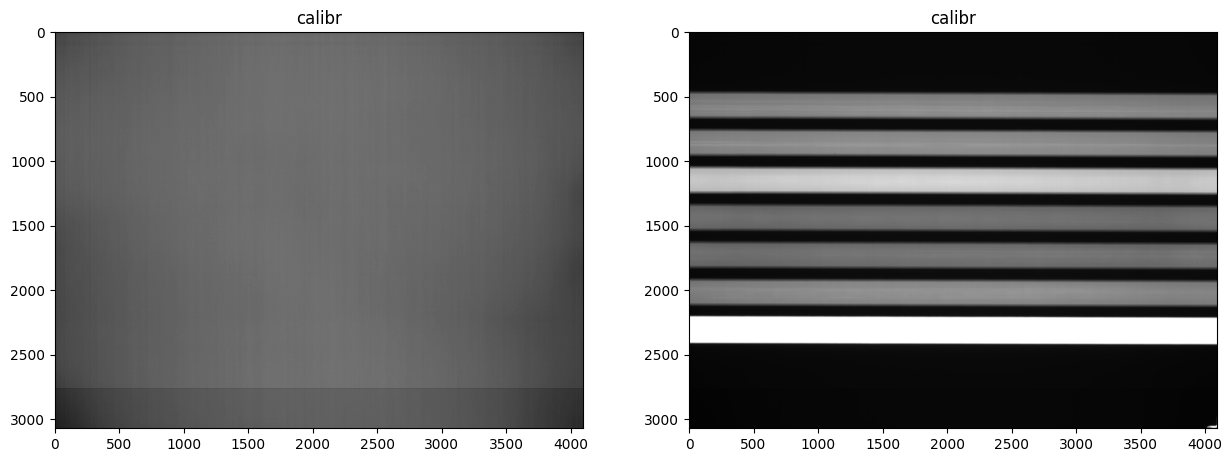

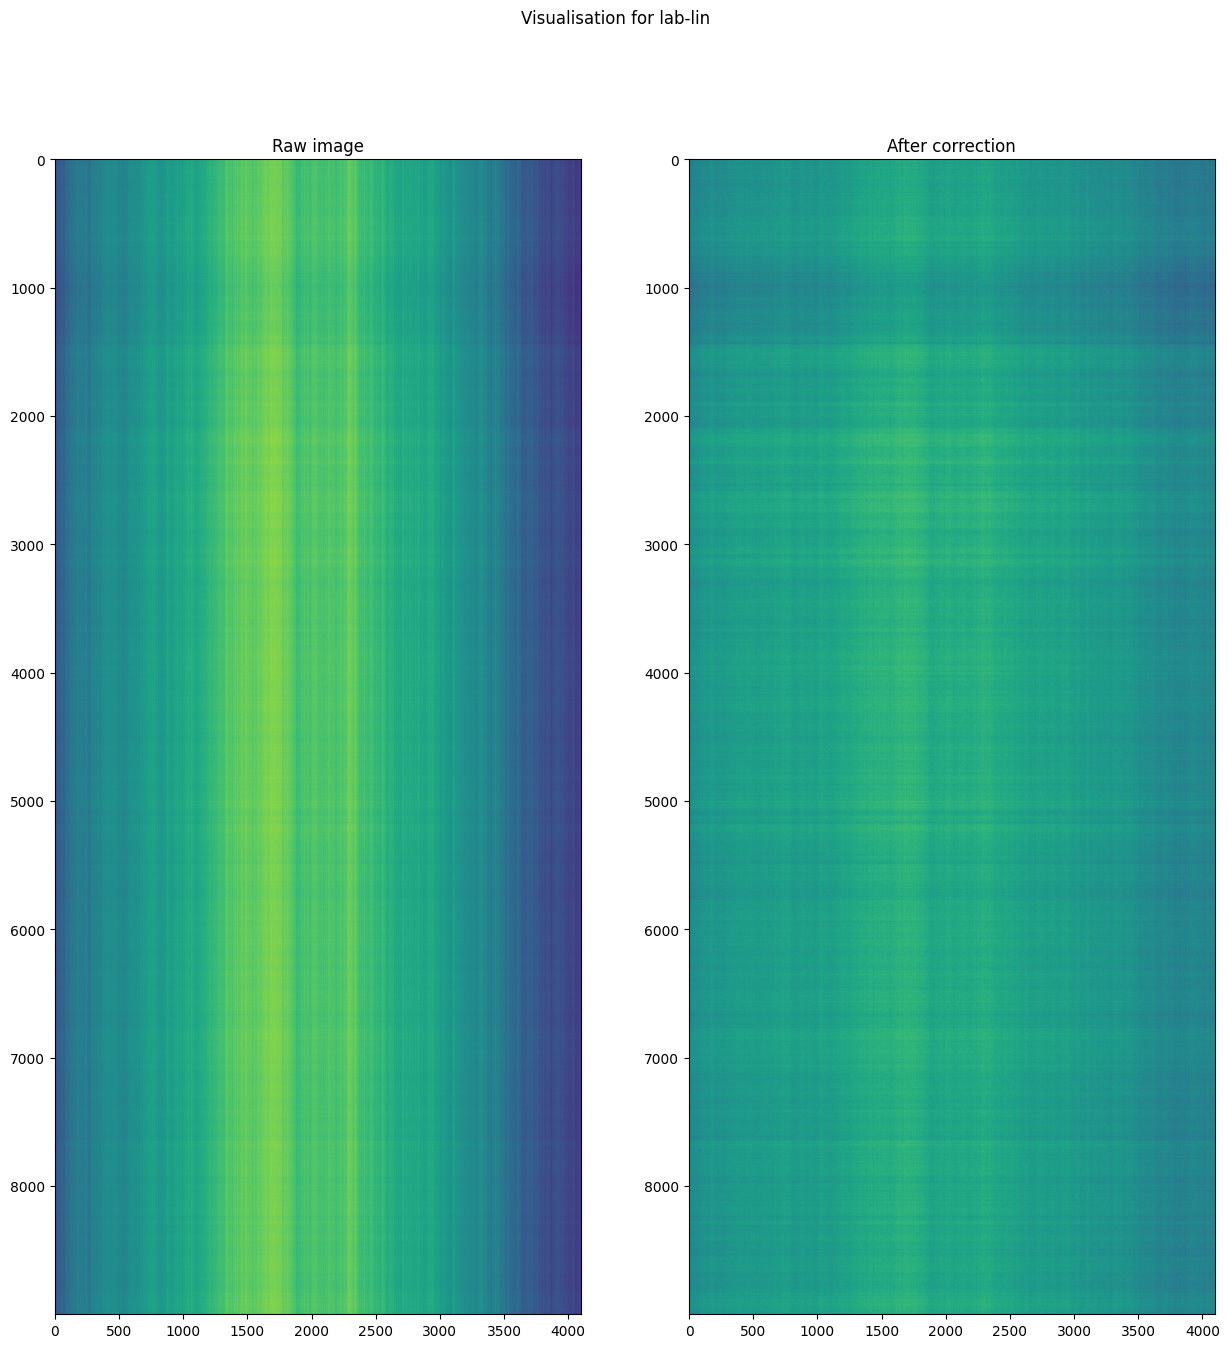

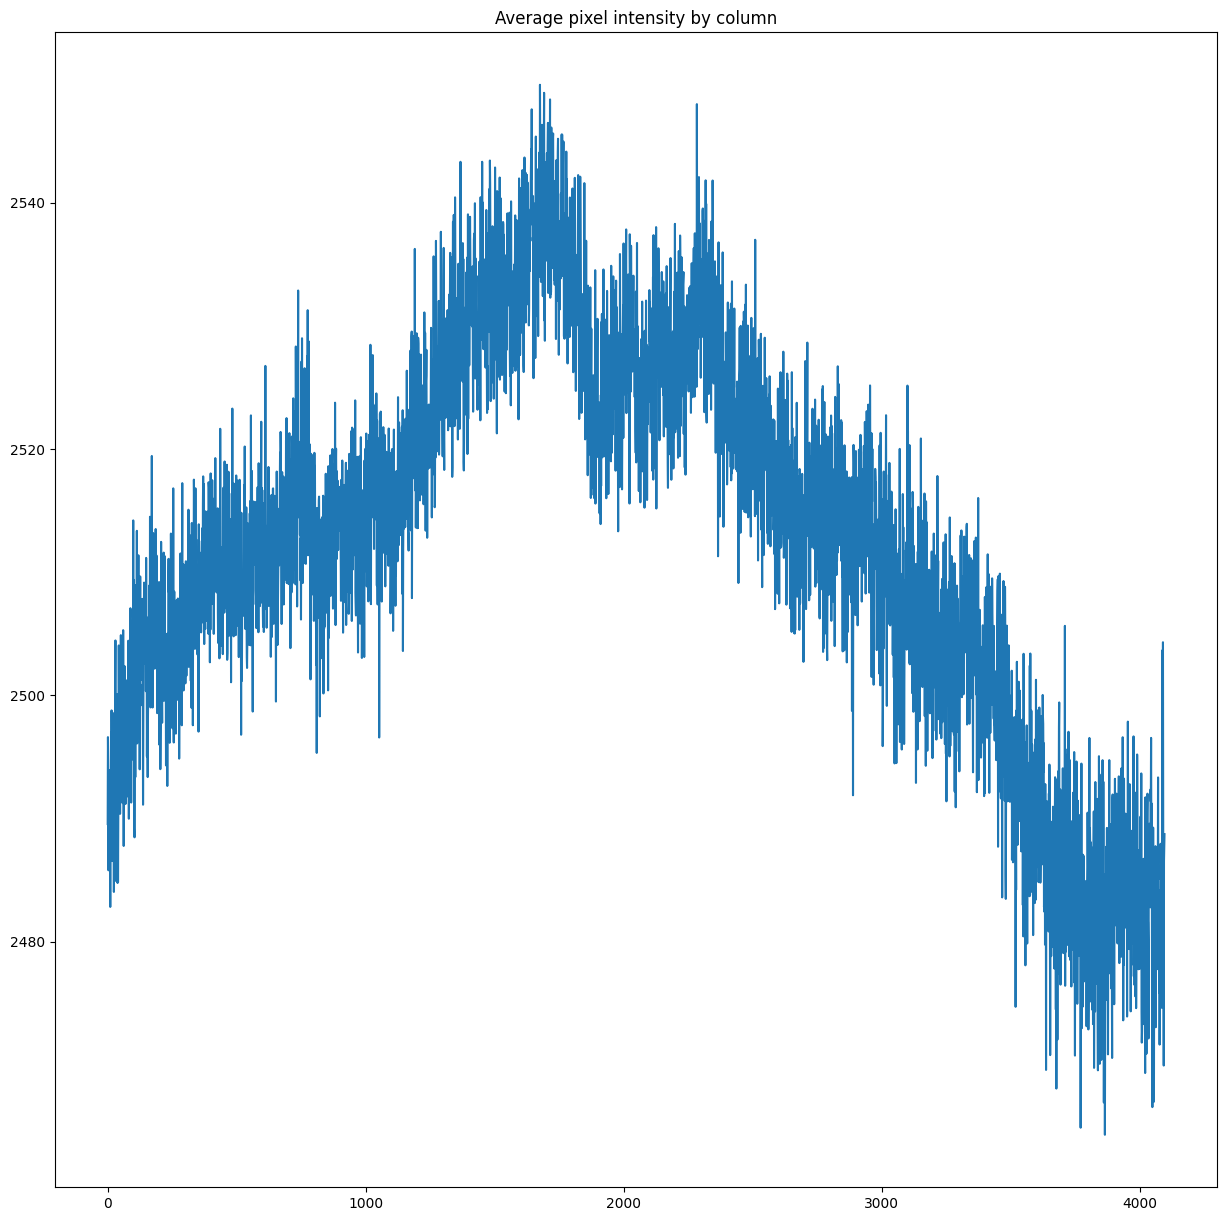

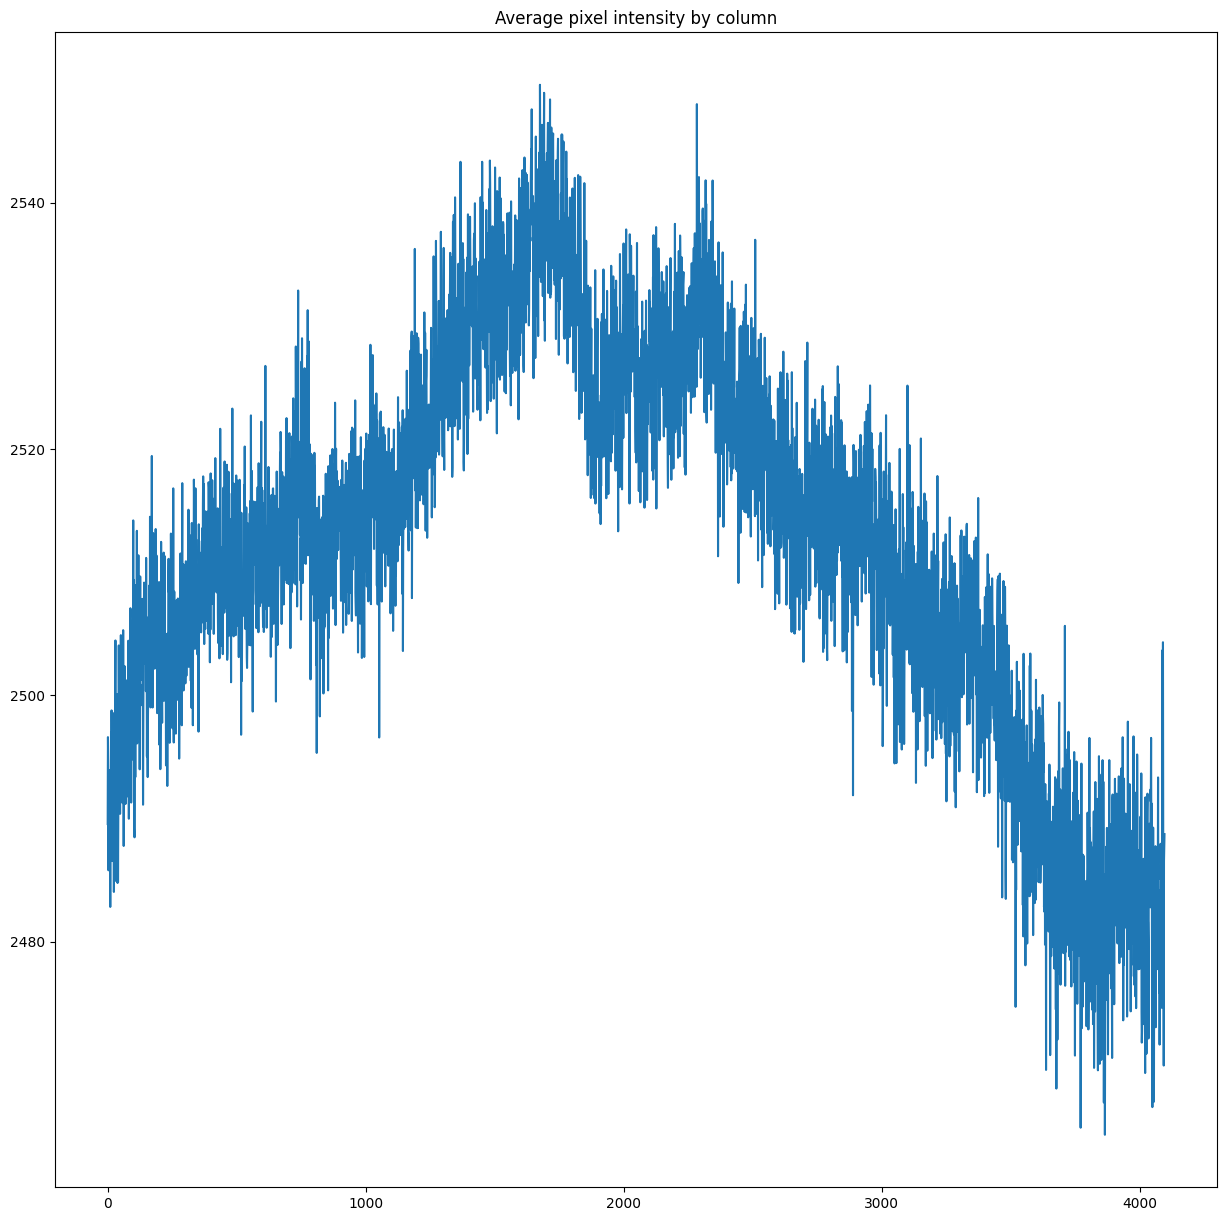

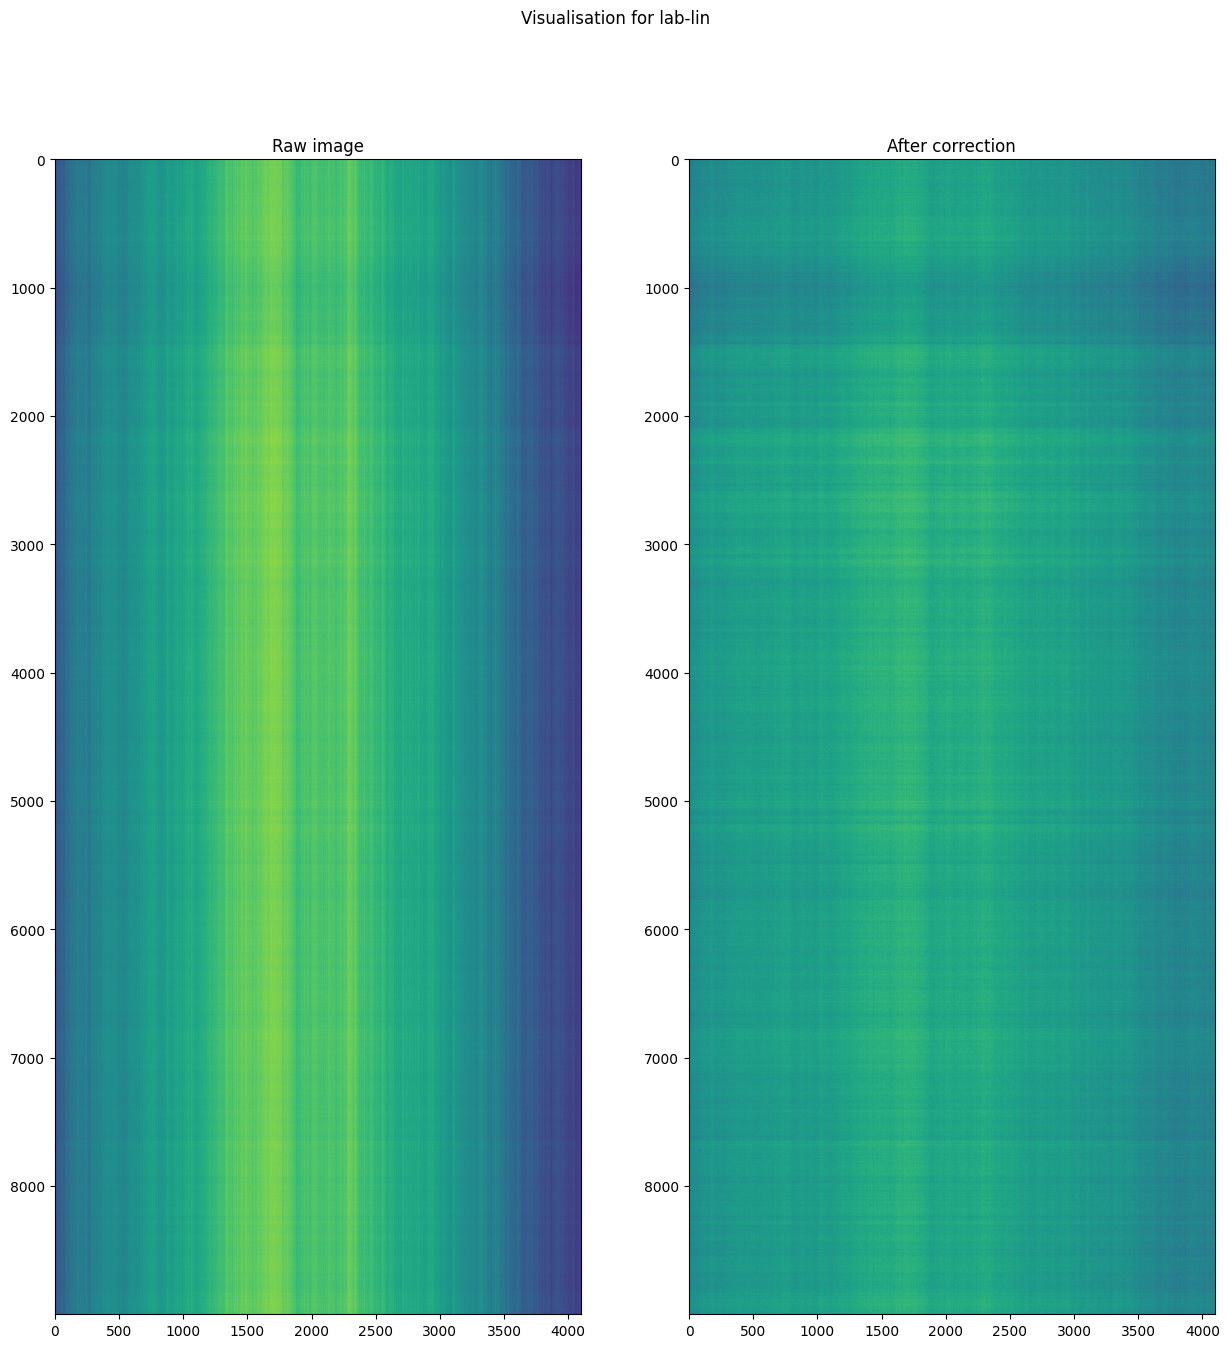

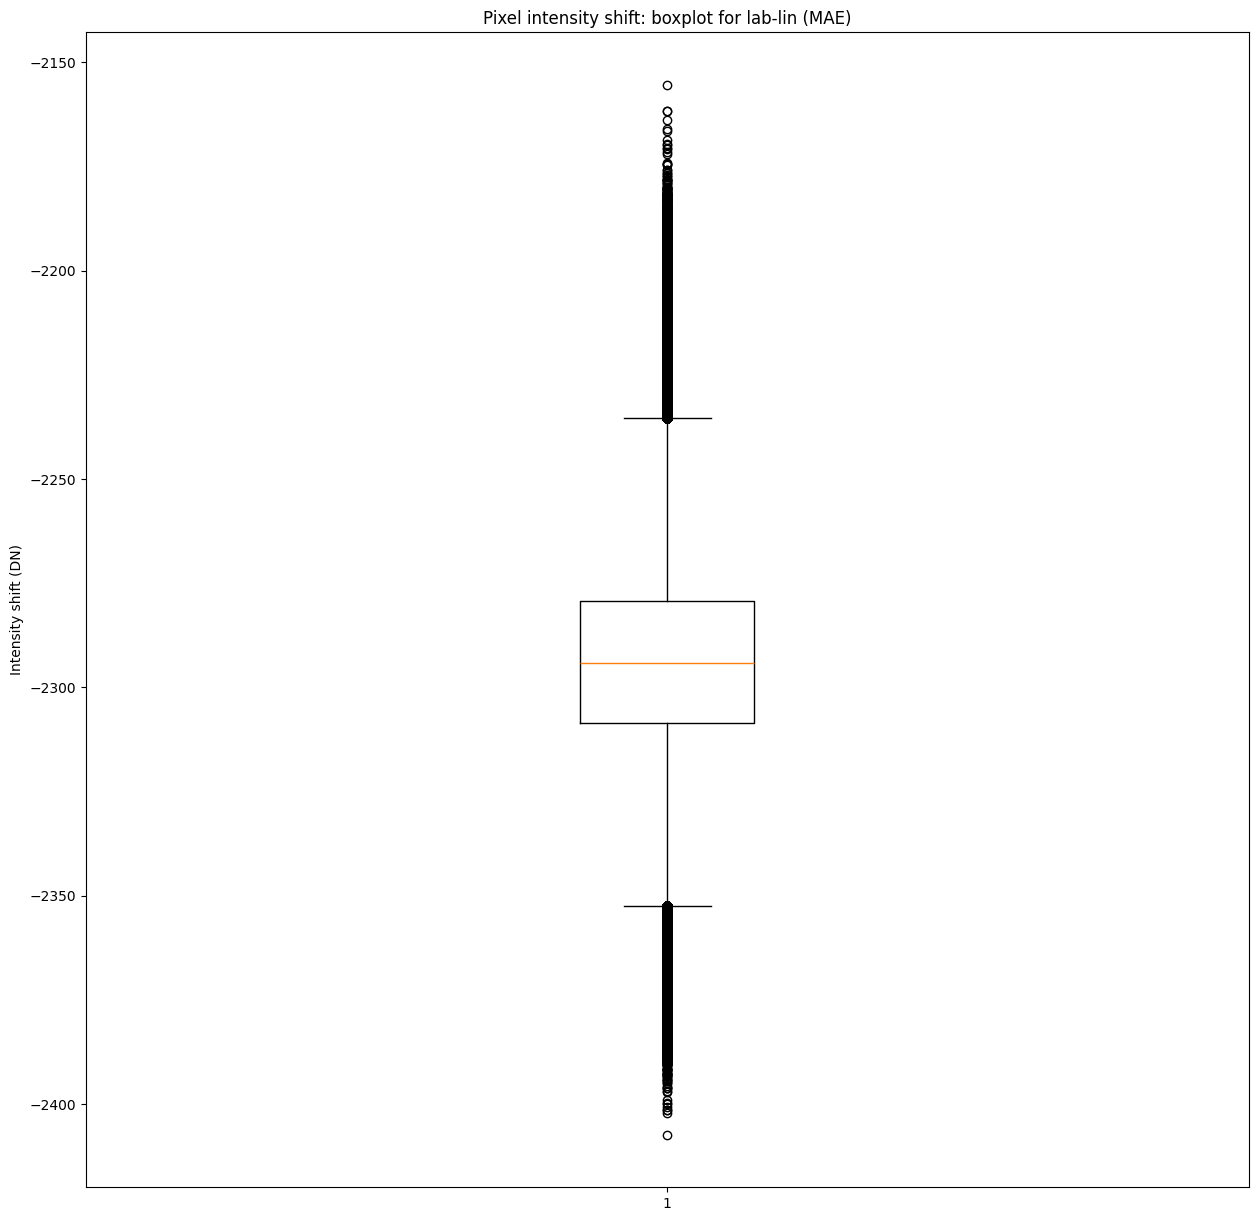

Metrics (lab-lin)
MSE          5261437.71
SNR               94.61
PSNR             312.09

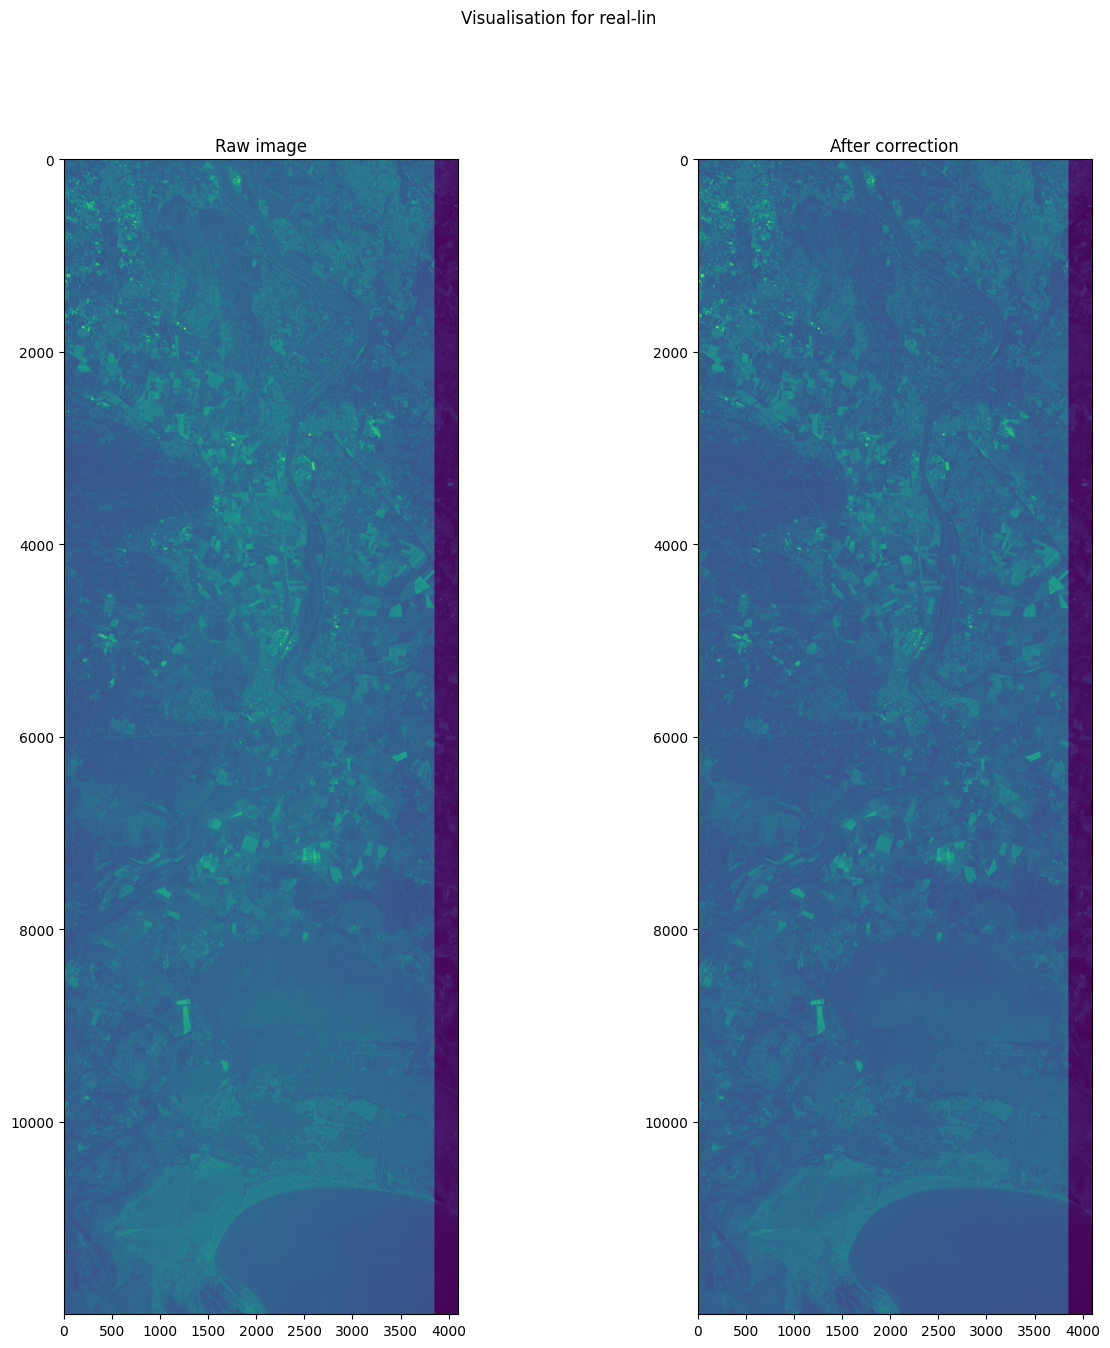

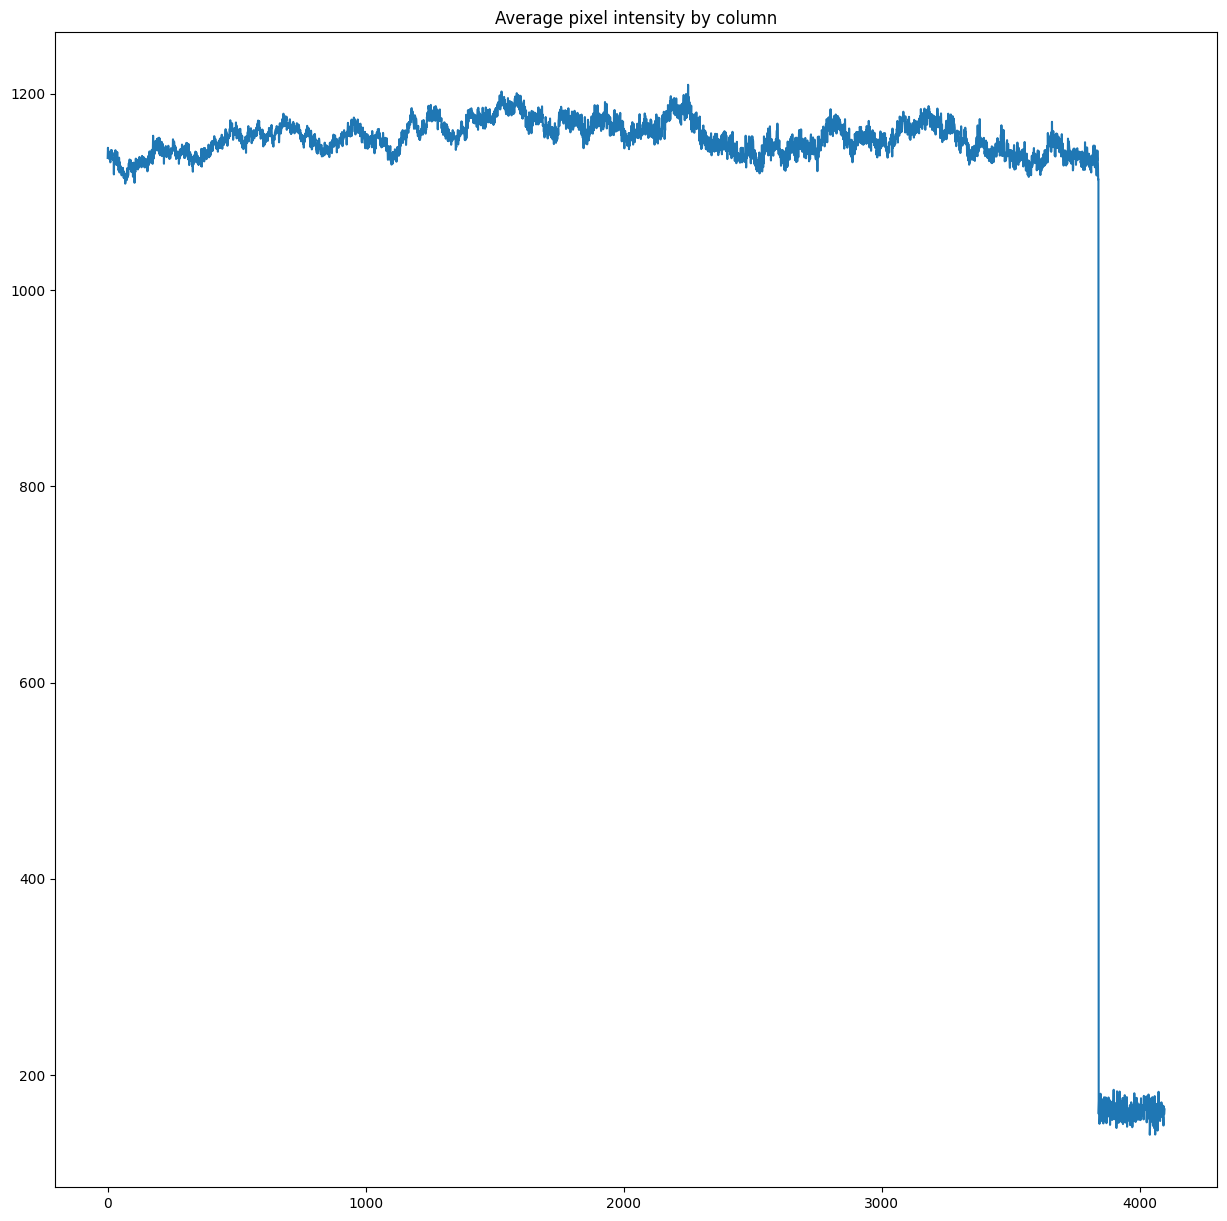

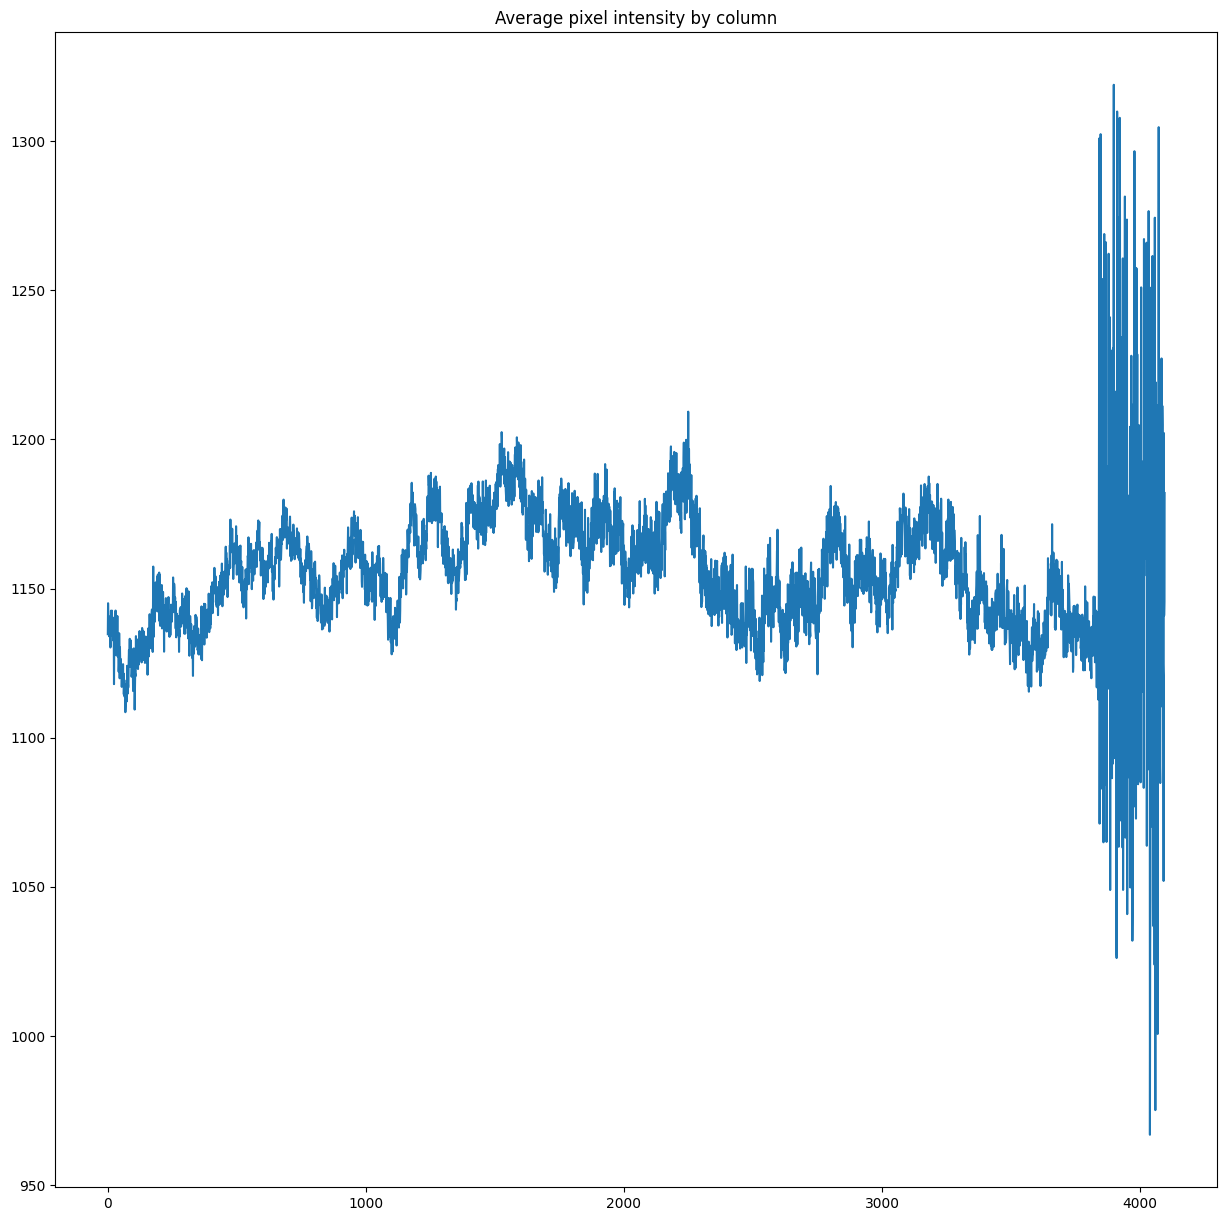

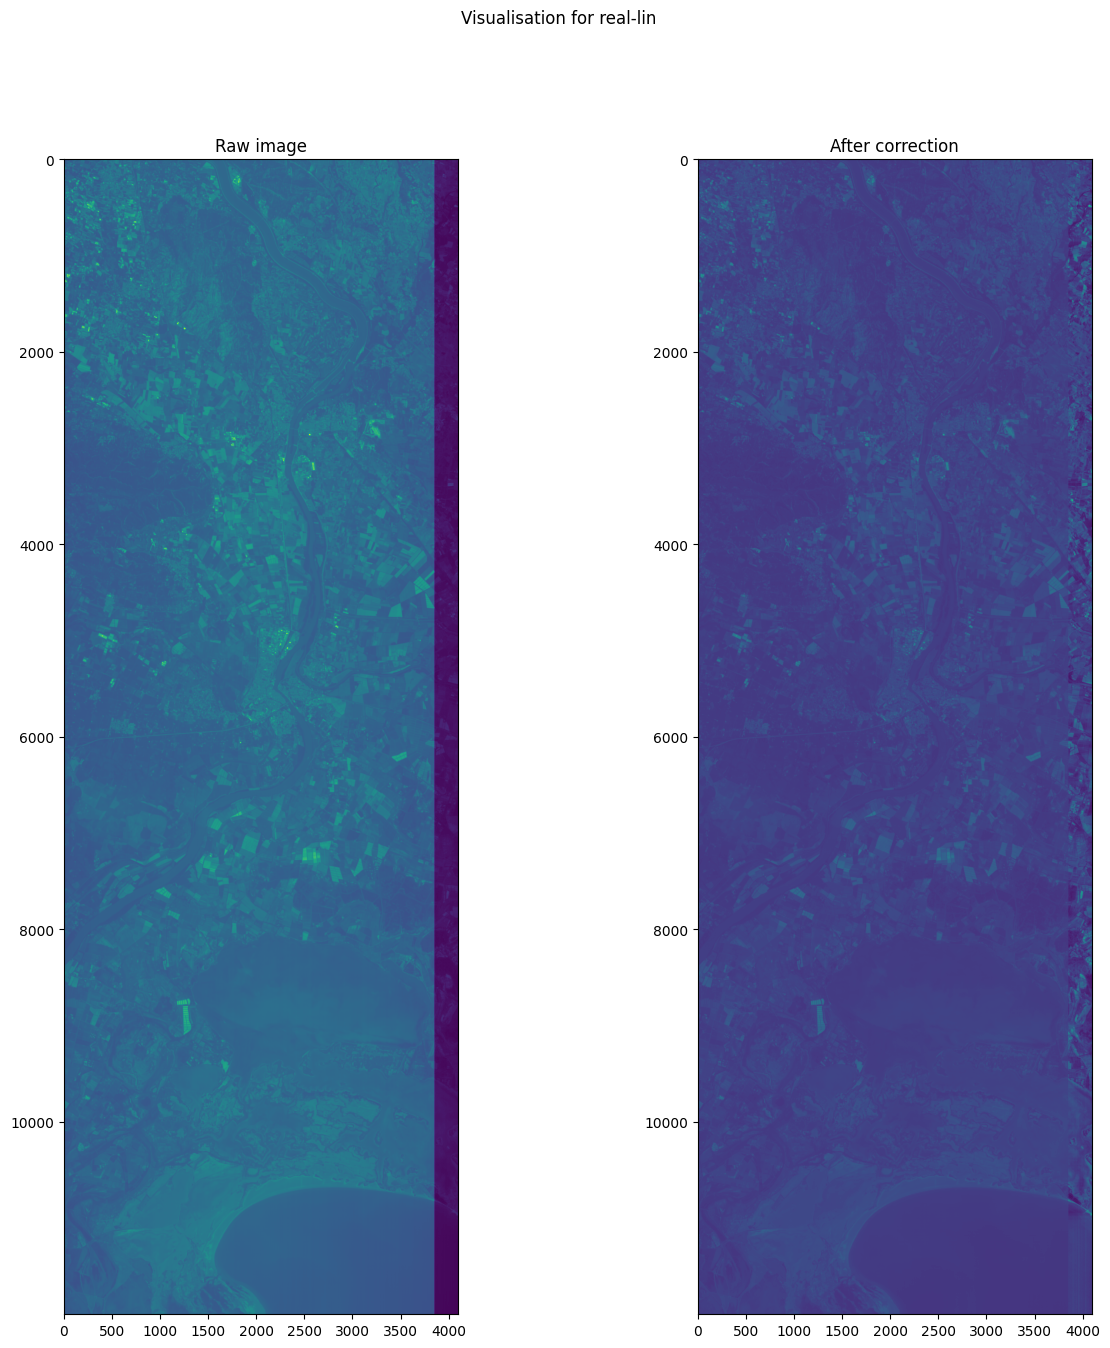

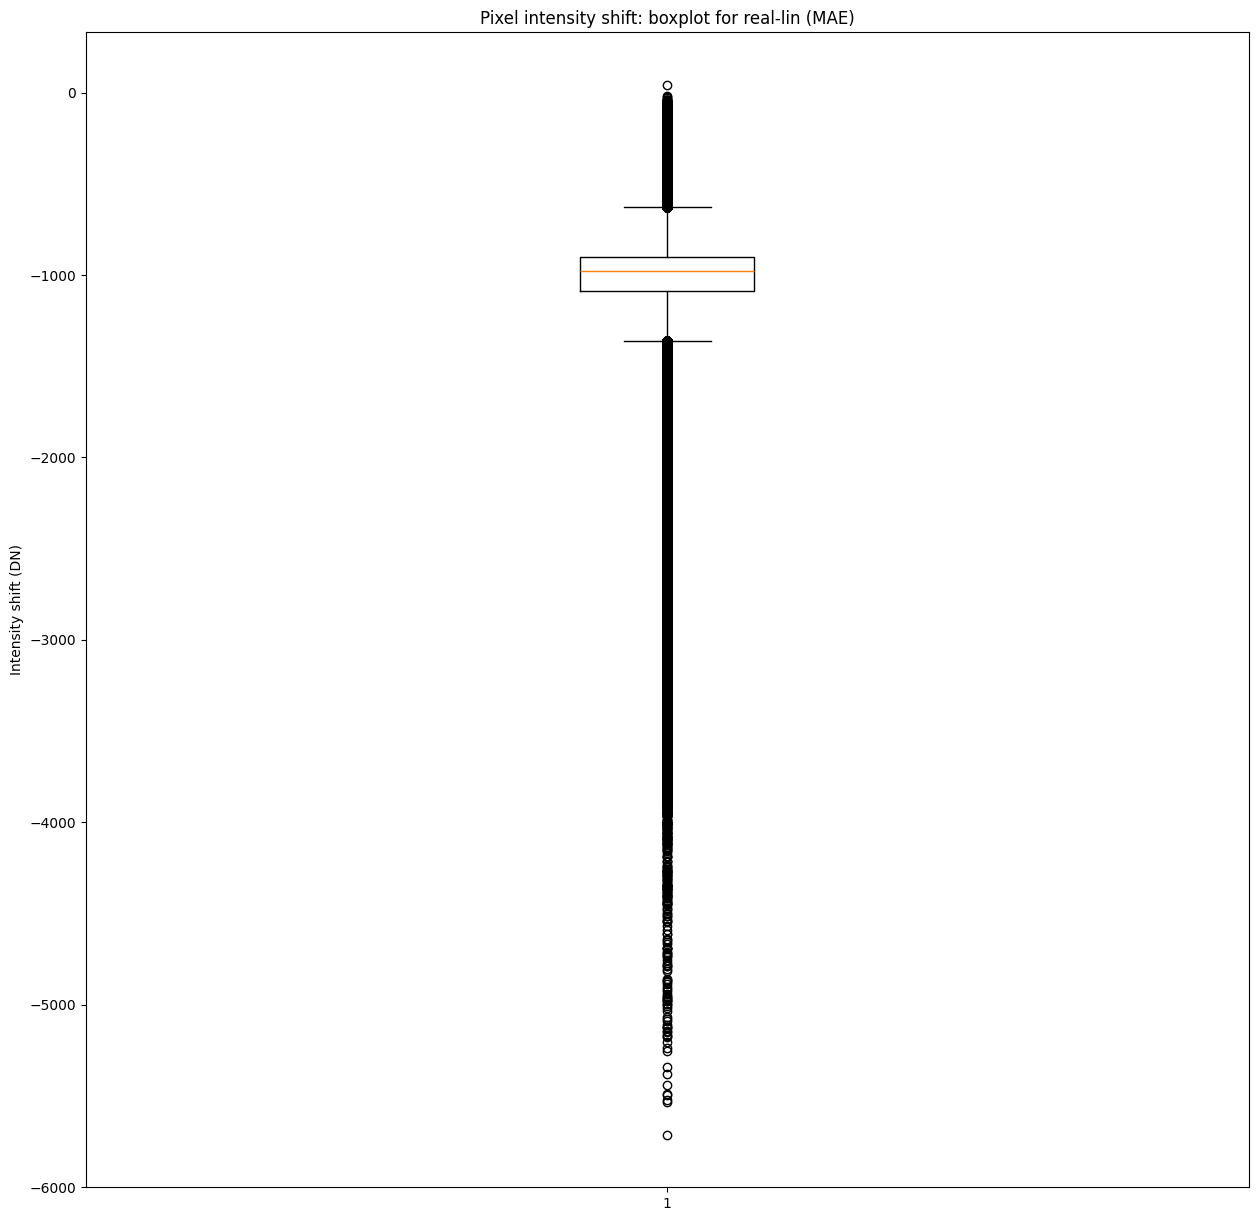

Metrics (real-lin)
MSE           1063078.23
SNR                 6.09
PSNR              319.03

In [16]:
if __name__ == '__main__':
    
    # Read the calibration files
    darkfield, flatfield = [CalibImg(cal) for cal in glob('data/calibration/*.tiff')]
    
    # Visualise the darkfield and flatfield
    visCalibFields(darkfield, flatfield)
    
    # Read the tiff files
    tiffs = [tf for tf in glob('data/lab-linescan/*.tiff')]
    tiffs.extend([tf for tf in glob('data/real-linescan/*.tiff')])
    # Read the metadata files
    metas = [mt for mt in glob('data/lab-linescan/*.json')]
    metas.extend([mt for mt in glob('data/real-linescan/*.json')])
    warnings.filterwarnings("ignore")

    # Store images and their metadata in a dictionary while checking for radiometric errors
    imgs_raw = []
    #  Check sensor width to be used for bad line start errors
    sensor_width = darkfield.array.shape[1]
    for idx, (im, mt) in enumerate(zip(tiffs, metas)):        
        imgs_raw.append(RawImg(im, mt))
        # Check for common radiometric errors      
        radErrChecks(imgs_raw[idx], idx, sensor_width)
              
    # Apply flat-field correction (FFC) to the raw images
    imgs_ffc = []
    for img in imgs_raw:
        imgs_ffc.append(applyFFC(img, darkfield, flatfield))

    # Create an image object for additional corrections
    for idx, (im_ffc, im_raw) in enumerate(zip(imgs_ffc, imgs_raw)):
        imgs_ffc[idx] = CorrectedImg(im_ffc, im_raw, idx)
        
    # Apply additional corrections, visualise changes and compute statistics
    warnings.filterwarnings("ignore")
    for idx, (im_ffc, im_raw) in enumerate(zip(imgs_ffc, imgs_raw)):
    
        visPrePost(im_raw, im_ffc.array)
        # Additional correction
        corrected = im_ffc.histCorr()
        corrected = CorrectedImg(corrected, im_raw, idx)
        visPrePost(im_raw, corrected.array)        
        corrMetrics(im_raw, corrected.array)
        corrected.save()